In [19]:
import pandas as pd
import numpy as np

# 데이터 시각화
import matplotlib
import matplotlib.pyplot as plt

from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from statsmodels.api import Logit

from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix

In [3]:
df_raw = pd.read_csv("/home/piai/Downloads/bigdata_lec/HMEQ.csv")

In [4]:
df_raw.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [5]:
df_raw.isnull().sum(axis = 0)

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [6]:
df_raw["JOB"].fillna("Other",inplace = True)
df_raw.fillna(df_raw.mean(),inplace = True)

In [7]:
df_train, df_test = train_test_split(df_raw, test_size = 0.3,\
                                    random_state = 1234)

print("train data size: {}".format(df_train.shape))
print("test data size: {}".format(df_test.shape))

train data size: (2623, 13)
test data size: (1125, 13)


In [8]:
log_model = Logit.from_formula("""BAD ~ LOAN + MORTDUE + VALUE + C(REASON) + C(JOB)+ YOJ + DEROG + DELINQ + CLAGE + NINQ + CLNO + DEBTINC""", df_train)
-
log_result = log_model.fit()
print(log_result.summary())

Optimization terminated successfully.
         Current function value: 0.237614
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 2623
Model:                          Logit   Df Residuals:                     2606
Method:                           MLE   Df Model:                           16
Date:                Thu, 09 Jul 2020   Pseudo R-squ.:                  0.2257
Time:                        11:15:14   Log-Likelihood:                -623.26
converged:                       True   LL-Null:                       -804.91
Covariance Type:            nonrobust   LLR p-value:                 1.743e-67
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -5.0942      0.560     -9.100      0.000      -6.191      -3.997

### Office는 매니저 대비 BAD일 확률이 -이다.
### Sales는 매니저 대비 BAD일 확률이 +이다.

H0: 베타(기울기,계수) = 0

H1: 

YOJ pvalue가 0.645로 0.5보다 크다. => H0 채택


In [15]:
y_pred = log_result.predict(df_test)
y_pred_class = (y_pred > 0.5).astype(int)
y_pred_class.head() #우리가 관심있는 사건이 일어날 확률

1721    0
822     0
1686    0
789     0
165     0
dtype: int64

In [11]:
print("Accuracy: {0:.3f}\n".format(accuracy_score(df_test["BAD"], y_pred_class)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test["BAD"], y_pred_class)))

Accuracy: 0.924

Confusion Matrix: 
[[1017    4]
 [  81   23]]


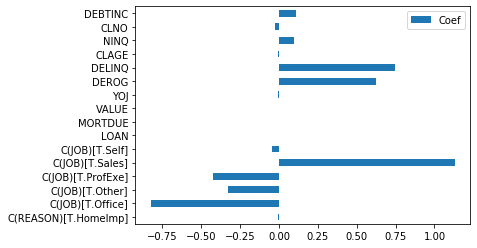

In [12]:
df_logistic_coef = pd.DataFrame({"Coef":log_result.params.values[1:]}, index = log_model.exog_names[1:])

df_logistic_coef.plot.barh(y= "Coef")

영향을 많이 주는 인자들.

그리고 방향성도 고려해야한다.

언제 BAD가 1이 되나? 

직업이 Sales일 경우에는 1이 될 확률이 높다.

일종의 Fraud.

Office는 반대로..

DELINQ가 증가할수록 위험해진다(BAD).

In [14]:
df_char = df_raw.select_dtypes(include="object")
df_numeric = df_raw.select_dtypes(exclude = "object")

scaler = StandardScaler()
np_numeric_scaled = scaler.fit_transform(df_numeric)
df_numeric_scaled = pd.DataFrame(np_numeric_scaled, columns = df_numeric.columns)

df_scaled = pd.concat([df_numeric_scaled, df_char], axis=1)
df_scaled.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON,JOB
0,3.140664,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,HomeImp,Other
1,3.140664,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,HomeImp,Other
2,-0.318404,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,HomeImp,Office
3,3.140664,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,HomeImp,Mgr
4,-0.318404,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,HomeImp,Office


In [16]:
df_scaled["BAD"] = np.where(df_scaled["BAD"]>0,1,0)
df_scaled.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON,JOB
0,1,-1.559587,-0.993626,-1.224910,-0.017563,-0.267462,-0.342558,-0.967342,-0.018776,-1.428350,0.356347,HomeImp,Other
1,1,-1.550817,-1.039240,-1.174897,0.251809,-0.267462,-0.342558,-1.122053,-0.666629,-1.428350,0.329025,HomeImp,Other
2,0,-1.506968,0.607570,0.260973,-0.960364,-0.267462,-0.342558,-1.094930,-0.666629,-0.905133,-0.303684,HomeImp,Office
3,1,-1.498198,-0.897428,-1.093133,0.386495,-0.267462,-0.342558,-1.344679,-0.018776,-0.067985,0.493725,HomeImp,Mgr
4,0,-1.498198,0.520156,0.191721,-0.690992,-0.267462,-0.342558,-1.060586,-0.666629,-0.905133,-0.531456,HomeImp,Office


In [17]:
# 코드 추가 작성 필요

# 의사결정나무

In [24]:
from sklearn.tree import export_graphviz
import graphviz

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [35]:
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [36]:
df_raw_dummy.isnull().sum(axis = 0)

BAD               0
LOAN              0
MORTDUE           0
VALUE             0
YOJ               0
DEROG             0
DELINQ            0
CLAGE             0
NINQ              0
CLNO              0
DEBTINC           0
REASON_DebtCon    0
REASON_HomeImp    0
JOB_Mgr           0
JOB_Office        0
JOB_Other         0
JOB_ProfExe       0
JOB_Sales         0
JOB_Self          0
dtype: int64

In [37]:
#목표 변수, 설명 변수 데이터 지정
df_raw_dummy_y = df_raw_dummy["BAD"]

df_raw_dummy_x = df_raw_dummy.drop("BAD", axis=1, inplace = False)


#결측치 제거는 위에서 회귀할때 해줬기 때문에 따로 안해주는것으로 한다.

In [38]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_dummy_x, df_raw_dummy_y, test_size = 0.3,\
                                    random_state = 1234)

print("train X data size: {}".format(df_train_x.shape))
print("train Y data size: {}".format(df_train_y.shape))
print("test X data size: {}".format(df_test_x.shape))
print("test Y data size: {}"
#결측치 제거는 위에서 회귀할때 해줬기 때문에 따로 안해주는것으로 한다..format(df_test_y.shape))

train X data size: (2623, 18)
train Y data size: (2623,)
test X data size: (1125, 18)
test Y data size: (1125,)


In [39]:
tree_uncustomized = DecisionTreeClassifier(random_state =1234)
tree_uncustomized.fit(df_train_x,df_train_y)

print("Accuracy on training set: {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))

print("Accuracy on test set: {:.3f}".format(tree_uncustomized.score(df_test_x,df_test_y)))

Accuracy on training set: 1.000
Accuracy on test set: 0.932


In [40]:
train_accuracy = []; test_accuracy = []

para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    tree = DecisionTreeClassifier(max_depth = v_max_depth, random_state = 1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x, df_train_y))
    test_accuracy.append(tree.score(df_test_x, df_test_y))
    
df_accuracy_depth = pd.DataFrame()
df_accuracy_depth["Depth"] = para_depth
df_accuracy_depth["TrainAccuracy"] = train_accuracy
df_accuracy_depth["TestAccuracy"] = test_accuracy

In [41]:
df_accuracy_depth.round(3)
#결측치 제거는 위에서 회귀할때 해줬기 때문에 따로 안해주는것으로 한다.)

,Depth,TrainAccuracy,TestAccuracy
0,1,0.926,0.924
1,2,0.931,0.927
2,3,0.934,0.921
3,4,0.937,0.928
4,5,0.940,0.930
5,6,0.941,0.930
6,7,0.947,0.935
7,8,0.951,0.933
8,9,0.957,0.933
9,10,0.960,0.938


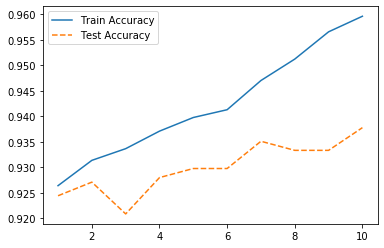

In [42]:
plt.plot(para_depth, train_accuracy, linestyle="-", label = "Train Accuracy")
plt.plot(para_depth, test_accuracy, linestyle="--", label = "Test Accuracy")
plt.legend()

In [43]:
v_feature_name = df_train_x.columns

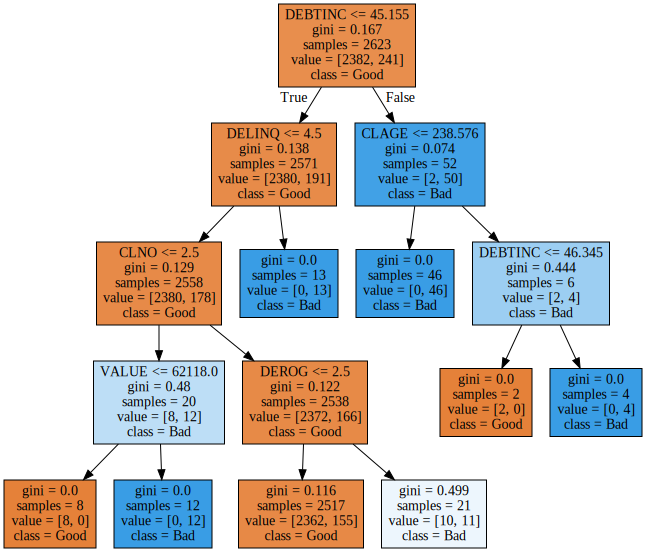

In [44]:
tree_low = DecisionTreeClassifier(max_depth = 4, random_state =1234)
tree_low.fit(df_train_x, df_train_y)

export_graphviz(tree_low, out_file = "tree_low.dot", class_names = ["Good","Bad"],
               feature_names = v_feature_name, impurity = True, filled = True)

with open("tree_low.dot") as f :
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

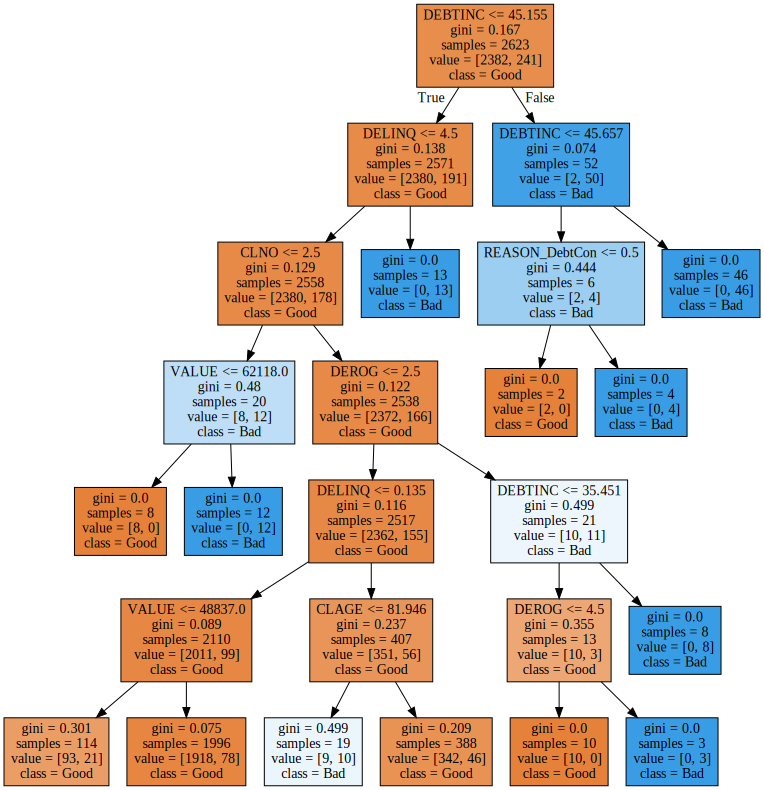

In [45]:
tree_high = DecisionTreeClassifier(max_depth = 6, random_state = 1234)
tree_high.fit(df_train_x,df_train_y)
export_graphviz(tree_high, out_file = "tree_high.dot", class_names = ["Good","Bad"],
               feature_names = v_feature_name, impurity = True, filled = True)
with open("tree_high.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [47]:
train_accuracy = []; test_accuracy = []
para_split = [n_split * 10 for n_split in range(1,11)]

#결측치 제거는 위에서 회귀할때 해줬기 때문에 따로 안해주는것으로 한다.
for v_min_samples_split in para_split:
    tree = DecisionTreeClassifier(min_samples_split = v_min_samples_split, max_depth =4, random_state =1234)
    tree.fit(df_train_x, df_train_y)
    train_accuracy.append(tree.score(df_train_x,df_train_y))
    test_accuracy.append(tree.score(df_test_x,df_test_y))
    
df_accuracy_split = pd.DataFrame()
df_accuracy_split["MinSamplesSplit"] = para_split
df_accuracy_split["TrainAccuracy"] = train_accuracy
df_accuracy_split["TestAccuracy"] = test_accuracy

In [48]:
df_accuracy_split.round(3)

,MinSamplesSplit,TrainAccuracy,TestAccuracy
0,10,0.936,0.928
1,20,0.936,0.928
2,30,0.933,0.921
3,40,0.933,0.921
4,50,0.933,0.921
5,60,0.933,0.921
6,70,0.933,0.921
7,80,0.933,0.921
8,90,0.933,0.921
9,100,0.933,0.921


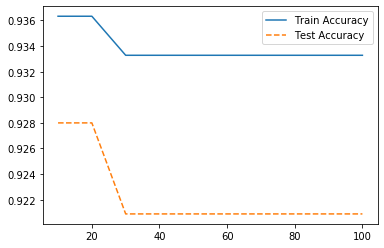

In [49]:
plt.plot(para_split, train_accuracy, linestyle = "-", label = "Train Accuracy")
plt.plot(para_split, test_accuracy, linestyle = "--", label =
#결측치 제거는 위에서 회귀할때 해줬기 때문에 따로 안해주는것으로 한다. "Test Accuracy")
plt.legend()

### @ 해석 :20 이상 -> 모델 정확도가 급격히 감소함

### 분리 노드의 최소 샘플 수 (min_samples_split)에 따른 차이

# 통신 고객 실습

In [50]:
df_raw = pd.read_csv("/home/piai/Downloads/bigdata_lec/통신고객이탈.csv")

In [51]:
df_raw.head()

,CHURN,CUSTOMER_ID,GENDER,AGE,CHARGE_TYPE,HANDSET,USAGE_BAND,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
0,Active,K102990,F,31,CAT 100,ASAD170,Med,33.33,6,218,379.8,9,21.6,366,632.4
1,Active,K103280,M,27,CAT 100,S50,Med,30.87,10,373,656.4,11,28.0,411,810.4
2,Active,K103660,M,27,CAT 100,ASAD170,Med,49.40,11,260,582.0,0,0.0,265,614.1
3,Active,K103730,M,61,CAT 100,ASAD170,Med,48.60,1,294,661.8,14,101.5,326,844.0
4,Active,K104560,F,52,CAT 100,S50,Med,56.03,0,221,555.6,7,25.0,274,673.0


In [53]:
df_raw_x = df_raw.drop(["CHURN","CUSTOMER_ID"], axis =1, inplace =False)
df_raw_dummy = pd.get_dummies(df_raw_x)
df_raw_dummy.head()

,AGE,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME,GENDER_F,...,HANDSET_S80,HANDSET_SOP10,HANDSET_SOP20,HANDSET_WC95,USAGE_BAND_High,USAGE_BAND_Low,USAGE_BAND_Med,USAGE_BAND_MedHigh,USAGE_BAND_MedLow,USAGE_BAND_None
0,31,33.33,6,218,379.8,9,21.6,366,632.4,1,...,0,0,0,0,0,0,1,0,0,0
1,27,30.87,10,373,656.4,11,28.0,411,810.4,0,...,0,0,0,0,0,0,1,0,0,0
2,27,49.40,11,260,582.0,0,0.0,265,614.1,0,...,0,0,0,0,0,0,1,0,0,0
3,61,48.60,1,294,661.8,14,101.5,326,844.0,0,...,0,0,0,0,0,0,1,0,0,0
4,52,56.03,0,221,555.6,7,25.0,274,673.0,1,...,0,0,0,0,0,0,1,0,0,0


#### 변수 역할 지정

In [61]:
df_raw_y = df_raw["CHURN"]
df_x_dummy = pd.get_dummies(df_raw_x)
df_raw_y = np.where(df_raw_y == "Active", 0, 1)

In [56]:
df_raw_dummy.isnull().sum(axis = 0)

AGE                     0
SERVICE_DURATION        0
DROPPED_CALLS           0
PEAK_CALLS_NO           0
PEAK_CALLS_TIME         0
WEEKEND_CALLS_NO        0
WEEKEND_CALLS_TIME      0
TOTAL_CALLS_NO          0
TOTAL_CALLS_TIME        0
GENDER_F                0
GENDER_M                0
CHARGE_TYPE_CAT 100     0
CHARGE_TYPE_CAT 200     0
CHARGE_TYPE_CAT 50      0
CHARGE_TYPE_Play 100    0
CHARGE_TYPE_Play 300    0
HANDSET_ASAD170         0
HANDSET_ASAD90          0
HANDSET_BS110           0
HANDSET_BS210           0
HANDSET_CAS30           0
HANDSET_CAS60           0
HANDSET_S50             0
HANDSET_S80             0
HANDSET_SOP10           0
HANDSET_SOP20           0
HANDSET_WC95            0
USAGE_BAND_High         0
USAGE_BAND_Low          0
USAGE_BAND_Med          0
USAGE_BAND_MedHigh      0
USAGE_BAND_MedLow       0
USAGE_BAND_None         0
dtype: int64

In [60]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_dummy_x, df_raw_dummy_y, test_size = 0.3,\
                                    random_state = 1234)

print("train X data size: {}".format(df_train_x.shape))
print("train Y data size: {}".format(df_train_y.shape))
print("test X data size: {}".format(df_test_x.shape))
print("test Y data size: {}".format(df_test_y.shape))

train X data size: (2623, 18)
train Y data size: (2623,)
test X data size: (1125, 18)
test Y data size: (1125,)
